In [6]:


import json
import os
import shutil
import pandas as pd
import numpy as np
import datetime
import glob
from tqdm import tqdm
import unidecode
import subprocess
import  tarfile
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
import ast
import zipfile



# Le Figaro


## Processing the data

In [7]:
json_files = glob.glob('/scratch/students/bousbina/corpus/France/le_figaro/**/*.json', recursive=True)

# Count the number of files, which represents the number of articles
num_articles = len(json_files)

print("Total number of articles:", num_articles)

Total number of articles: 28503


In [18]:
os.makedirs('/scratch/students/bousbina/corpus/France/filtered_files_president', exist_ok=True)

     
                    
# Traverse all JSON files
json_count = 0
filter_count = 0
for root, dirs, files in os.walk('/scratch/students/bousbina/corpus/France/le_figaro'):
    for file_name in files:
        if file_name.endswith('.json'):
            with open(os.path.join(root, file_name)) as json_file:
                json_text = json.load(json_file)
                json_count += 1
                if "président" in json.dumps(json_text):
            # Copy file in filtered file directoy
                    shutil.copyfile(os.path.join(root, file_name), os.path.join('/scratch/students/bousbina/corpus/France/filtered_files_president', file_name))
                    filter_count += 1
                    print(filter_count)
                

                    

In [19]:
print(f"Found {json_count} JSON files in the directory")
dir_path = '/scratch/students/bousbina/corpus/France/filtered_files_president'
count = 0
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1

print(f"Found  {count} JSON filtered files according to the word president")

Found 28503 JSON files in the directory
Found  855 JSON filtered files according to the word president


## Counting the number and the length of articles


In [20]:


if not os.path.exists("/scratch/students/bousbina/corpus/France/data"):
    os.makedirs("/scratch/students/bousbina/corpus/France/data")

# Get list of all articles
every_article = glob.glob('/scratch/students/bousbina/corpus/France/filtered_files_president/*.json')
president_articles = pd.DataFrame(columns=["publication_date", "content"])
dates_fr = set()


for article in tqdm(every_article):
    date = article.split("/")[-1][:10]
    dates_fr.add(date)
    with open(article, 'r') as f:
        data = json.load(f)   
        if any(x in unidecode.unidecode(str.lower(data["contentAsText"][0])) for x in ('président')):
            # Increment counters and append data to dataframe
            president_articles.loc[date] = {"publication_date" : date, "content": data["contentAsText"][0]}

#Sort the dataframe by publication dates            
president_articles.sort_values(by=["publication_date"], inplace=True)

# Save data
president_articles.to_csv("/scratch/students/bousbina/corpus/France/data/president_articles_fr.csv")

# Save dates
with open('/scratch/students/bousbina/corpus/France/data/dates_fr.txt', 'w') as f:
    # parse dates as datetime objects and sort them
    dates_fr_sorted = sorted([datetime.datetime.strptime(date, '%Y%m%d.m') for date in dates_fr])
    # convert datetime objects back to strings in the desired format and write them to file
    f.write('\n'.join([date.strftime('%Y%m%d.m') for date in dates_fr_sorted]))





100%|██████████████████████████████████████████████████████████████| 855/855 [00:11<00:00, 73.60it/s]


## Counting raw "président" frequency in the corpus

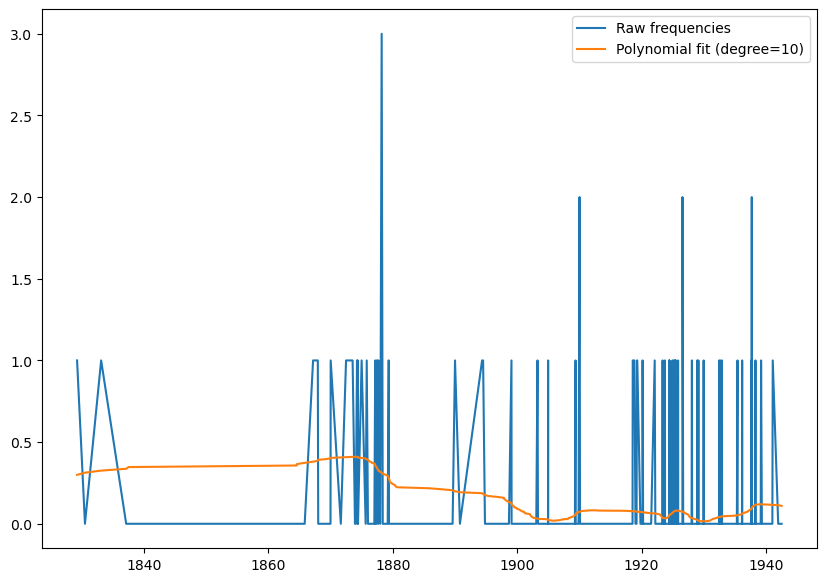

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("/scratch/students/bousbina/corpus/France/data/president_articles_fr.csv")
df = df.sort_values(by="publication_date")

# Convert the name of the column "publication_date" from string to date format
df["publication_date"] = pd.to_datetime(df["publication_date"], format="%Y%m%d.m").dt.date

# Set index to publication_date column
df = df.set_index("publication_date")

# We define a function that counts raw frequency
def count_word_frequency(word, text):
    return text.count(word)

# Create a new column in the dataframe for the raw frequency of the word in each row using the apply() method and the count_word_frequency() function.
word = "president"
df["frequency"] = df["content"].apply(lambda x: count_word_frequency(word, x))

# Fit a polynomial regression to the raw frequency data using numpy.polyfit() and numpy.polyval().
x = np.arange(len(df.index))
y = df["frequency"]
degree = 10  # Change the degree of the polynomial regression here
coeffs = np.polyfit(x, y, degree)
frequencies_polyfit = np.polyval(coeffs, x)

# Plot the raw frequencies and the polynomial fit using Matplotlib.
plt.figure(figsize=(10, 7))
plt.plot(df.index, df["frequency"], label="Raw frequencies")
plt.plot(df.index, frequencies_polyfit, label=f"Polynomial fit (degree={degree})")
plt.legend()
plt.show()


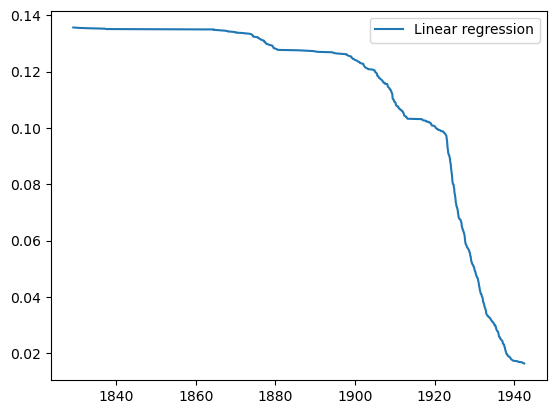

In [40]:
from sklearn.linear_model import LinearRegression

# Fit a linear regression model to the data
model = LinearRegression()
X = np.arange(len(df)).reshape(-1, 1)
y = df['frequency'].values.reshape(-1, 1)
model.fit(X, y)

# Add a regression line to the scatter plot
plt.plot(df.index, model.predict(X), label="Linear regression")
plt.legend()
plt.show()



## Observation of the trigram "le président" in four different blocks:
### [1840-1860] ,[1860-1880], [1880-1900], [1900-1920]

In [23]:
import nltk 
import datetime
nltk.download('punkt')
from nltk import ngrams
from nltk.text import Text
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.collocations import BigramAssocMeasures, TrigramAssocMeasures
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder


[nltk_data] Downloading package punkt to /home/bousbina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Dividing the dates into four blocks

In [24]:


# Load the CSV file into a pandas data frame
pd.options.mode.chained_assignment = None  # default='warn'
df = pd.read_csv("/scratch/students/bousbina/corpus/France/data/president_articles_fr.csv")

df['publication_date'] = pd.to_datetime(df['publication_date'], format='%Y%m%d.m').dt.date

# Define the date ranges
range1 = (datetime.datetime.strptime('18400101.m', '%Y%m%d.m').date(),
          datetime.datetime.strptime('18601231.m', '%Y%m%d.m').date())

range2 = (datetime.datetime.strptime('18600101.m', '%Y%m%d.m').date(),
          datetime.datetime.strptime('18801231.m', '%Y%m%d.m').date())

range3 = (datetime.datetime.strptime('18800101.m', '%Y%m%d.m').date(),
          datetime.datetime.strptime('19001231.m', '%Y%m%d.m').date())

range4 = (datetime.datetime.strptime('19000101.m', '%Y%m%d.m').date(),
          datetime.datetime.strptime('19201231.m', '%Y%m%d.m').date())

# Open the file and read the dates
with open('/scratch/students/bousbina/corpus/France/data/dates_fr.txt', 'r') as f:
    dates = f.read().splitlines()

# Convert the dates to date objects
dates = [datetime.datetime.strptime(date, '%Y%m%d.m').date() for date in dates]

block1 = df.loc[df["publication_date"].isin(dates) & df["publication_date"].between(range1[0], range1[1])]
new_value1 = block1["content"].apply(nltk.word_tokenize) 
block1.loc[:, "tokens"] =  new_value1

block2 = df.loc[df["publication_date"].isin(dates) & df["publication_date"].between(range2[0], range2[1])]
new_value2 = block2["content"].apply(nltk.word_tokenize) 
block2.loc[:, "tokens"] =  new_value2

block3 = df.loc[df["publication_date"].isin(dates) & df["publication_date"].between(range3[0], range3[1])]
new_value3 = block3["content"].apply(nltk.word_tokenize) 
block3.loc[:, "tokens"] =  new_value3

block4 = df.loc[df["publication_date"].isin(dates) & df["publication_date"].between(range4[0], range4[1])]
new_value4 = block4["content"].apply(nltk.word_tokenize) 
block4.loc[:, "tokens"] =  new_value4

# Print the number of dates in each block
print(f"Block 1 ({range1[0]} - {range1[1]}): {len(block1)} dates")
print(f"Block 2 ({range2[0]} - {range2[1]}): {len(block2)} dates")
print(f"Block 3 ({range3[0]} - {range3[1]}): {len(block3)} dates")
print(f"Block 4 ({range4[0]} - {range4[1]}): {len(block4)} dates")





Block 1 (1840-01-01 - 1860-12-31): 0 dates
Block 2 (1860-01-01 - 1880-12-31): 53 dates
Block 3 (1880-01-01 - 1900-12-31): 34 dates
Block 4 (1900-01-01 - 1920-12-31): 178 dates


In [25]:
import pandas as pd
from nltk import FreqDist



# Create a list of tri-grams in the tokenized text for each block
tri_grams_block_1 = [tri for doc in block1["tokens"] for tri in nltk.ngrams(doc, 3) if (("Le", "président", "est") == tri) ]
tri_grams_block_2 = [tri for doc in block2["tokens"] for tri in nltk.ngrams(doc, 3) if (("Le", "président", "est") == tri) ]
tri_grams_block_3 = [tri for doc in block3["tokens"] for tri in nltk.ngrams(doc, 3) if (("Le", "président", "est") == tri) ]
tri_grams_block_4 = [tri for doc in block4["tokens"] for tri in nltk.ngrams(doc, 3) if (("Le", "président", "est") == tri) ]

# Compute the frequency distribution of the tri-grams for each block
freq_dist_block_1 = FreqDist(tri_grams_block_1)
freq_dist_block_2 = FreqDist(tri_grams_block_2)
freq_dist_block_3 = FreqDist(tri_grams_block_3)
freq_dist_block_4 = FreqDist(tri_grams_block_4)

#Print all occurrences of the tri-gram "le président est" in each block of tokenized text,
print("Block 1 (1840-1860):")
print(tri_grams_block_1)
print("Block 2 (1860-1880):")
print(tri_grams_block_2)
print("Block 3 (1880-1900):")
print(tri_grams_block_3)
print("Block 4 (1900-1920):")
print(tri_grams_block_4)


#find the adjectifve after le président est







Block 1 (1840-1860):
[]
Block 2 (1860-1880):
[]
Block 3 (1880-1900):
[]
Block 4 (1900-1920):
[]


### Most common occurences in the blocks


In [26]:
# Print the five most common word uses of the tri-gram "le président est" in each block
print("Block 1 (1840-1860):")
print(freq_dist_block_1.most_common(5))
print("Block 2 (1860-1880):")
print(freq_dist_block_2.most_common(5))
print("Block 3 (1880-1900):")
print(freq_dist_block_3.most_common(5))
print("Block 4 (1900-1920):")
print(freq_dist_block_4.most_common(5))

Block 1 (1840-1860):
[]
Block 2 (1860-1880):
[]
Block 3 (1880-1900):
[]
Block 4 (1900-1920):
[]


### Occurences of  the two grams before and after “ président  ”

In [27]:
import re
import spacy
import string 
import pandas as pd
from nltk import FreqDist

In [35]:


# Create a list of two-grams in the tokenized text for block 1
two_grams_block_1_before = []
two_grams_block_1_after = []

punctuations = string.punctuation



for doc in block1["tokens"]:
    doc = [word for word in doc if word not in punctuations and not word.isdigit()]
    for i in range(len(doc)):
        if doc[i] == ("président"):
            if i > 1:
                two_grams_block_1_before.append((doc[i-2], doc[i-1]))
            if i < len(doc)-3:
                two_grams_block_1_after.append((doc[i+1], doc[i+2]))




# Compute the frequency distribution of the tri-grams for block 1
freq_dist_block_1_before = FreqDist(two_grams_block_1_before)
freq_dist_block_1_after = FreqDist(two_grams_block_1_after)


with open("two-grams-output_president.txt", "w") as file:
    # Write the two-grams before "président"
    file.write("-------------------------BLOCK_1-----------------------Two-grams before 'le président':\n")
    for two_gram in two_grams_block_1_before:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")
    # Write the two-grams after "président"
    file.write("-------------------------BLOCK_1-----------------------Two-grams after 'le président':\n")
    for two_gram in two_grams_block_1_after:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")

# Print all occurrences of the tri-gram "le président" in block of tokenized text
print("Block 1 (1840-1860): \n")
print(f"2-grams before 'le président': \n")
print(two_grams_block_1_before, "\n")
print(f"2-grams after 'le président': \n")
print(two_grams_block_1_after, "\n")
print("Most common 2-grams before: \n")
print(freq_dist_block_1_before.most_common(), "\n")
print("Most common 2-grams after: \n")
print(freq_dist_block_1_after.most_common())

Block 1 (1840-1860): 

2-grams before 'le président': 

[] 

2-grams after 'le président': 

[] 

Most common 2-grams before: 

[] 

Most common 2-grams after: 

[]


In [34]:
# Create a list of two-grams in the tokenized text for block 2
two_grams_block_2_before = []
two_grams_block_2_after = []





for doc in block2["tokens"]:
    doc = [word for word in doc if word not in punctuations and not word.isdigit()]
    for i in range(len(doc)):
        if doc[i] == ("président"):
            if i > 1:
                two_grams_block_2_before.append((doc[i-2], doc[i-1]))
            if i < len(doc)-3:
                two_grams_block_2_after.append((doc[i+1], doc[i+2]))




# Compute the frequency distribution of the tri-grams for block 1
freq_dist_block_2_before = FreqDist(two_grams_block_2_before)
freq_dist_block_2_after = FreqDist(two_grams_block_2_after)



with open("two-grams-output_president.txt", "a") as file:
    # Write the two-grams before "président"
    file.write("-------------------------BLOCK_2-----------------------Two-grams before 'président':\n")
    for two_gram in two_grams_block_2_before:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")
    # Write the two-grams after "président"
    file.write("-------------------------BLOCK_2-----------------------Two-grams after 'président':\n")
    for two_gram in two_grams_block_2_after:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")


# Print all occurrences of the tri-gram "président" in block of tokenized text
print("Block 2 (1860-1880): \n")
print(f"2-grams before 'le président': \n")
print(two_grams_block_2_before, "\n")
print(f"2-grams after 'le président': \n")
print(two_grams_block_2_after, "\n")
print("Most common 2-grams before: \n")
print(freq_dist_block_2_before.most_common(), "\n")
print("Most common 2-grams after: \n")
print(freq_dist_block_2_after.most_common())

Block 2 (1860-1880): 

2-grams before 'le président': 

[('M.', 'le'), ('M.', 'le'), ('Florence', 'le'), ('ans', 'le'), ('Scélérat', 'le'), ('Oui', 'le'), ('»', 'le'), ('de', "l'Ijnsfitut"), ('Saint-Roch', 'et'), ('«', 'Le'), ('m.', 'le'), ('m.', 'le'), ('si', 'le'), ('m.', 'le'), ('H.', 'le'), ('Eu', 'le'), ('u.', 'le'), ('M.', 'le'), ('M.', 'le'), ('m.', 'le'), ('bi', 'le'), ('si', 'le'), ('si', 'IM'), ('est', 'le'), ("l'arrivée", 'du'), ('1e', "''"), ('voter.', 'le'), ('m', 'le'), ('saucisson', 'le'), ('élection', 'le'), ('soncomble', 'le'), ('soir', 'le'), ('fort', 'le'), ('î', 'lè'), ('I', 'le'), ("L'hôtel", 'du'), ('dit', 'le'), ('M.', 'le'), ('monsieur', 'le'), ('sieur', 'le'), ('M.', 'le'), ('connu', 'du'), ('M.', 'le'), ('mie', 'qui'), ('larité', 'du'), ('glie', 'est'), ('mais', 'iô'), ("d'Au-", 'male'), ('mai', 'le'), ('M.', 'Javal'), ('dit', 'au'), ('par', 'le'), ('que', 'le'), ('M.', 'le'), ("''", 'le'), ('M.', 'le'), ('M.', 'le'), ('M.', 'le'), ('M.', 'le'), ('M.', 'le'), 

In [30]:
# Create a list of two-grams in the tokenized text for block 2
two_grams_block_3_before = []
two_grams_block_3_after = []



for doc in block3["tokens"]:
    doc = [word for word in doc if word not in punctuations and not word.isdigit()]
    for i in range(len(doc)):
        if doc[i] == ("président"):
            if i > 1:
                two_grams_block_3_before.append((doc[i-2], doc[i-1]))
            if i < len(doc)-3:
                two_grams_block_3_after.append((doc[i+1], doc[i+2]))




# Compute the frequency distribution of the tri-grams for block 1
freq_dist_block_3_before = FreqDist(two_grams_block_3_before)
freq_dist_block_3_after = FreqDist(two_grams_block_3_after)

with open("two-grams-output_president.txt", "a") as file:
    # Write the two-grams before "président"
    file.write("-------------------------BLOCK_3-----------------------Two-grams before 'président':\n")
    for two_gram in two_grams_block_2_before:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")
    # Write the two-grams after "président"
    file.write("-------------------------BLOCK_3-----------------------Two-grams after 'président':\n")
    for two_gram in two_grams_block_2_after:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")



# Print all occurrences of the tri-gram "président" in block of tokenized text
print("Block 3 (1880-1900): \n")
print(f"2-grams before 'le président': \n")
print(two_grams_block_3_before, "\n")
print(f"2-grams after 'le président': \n")
print(two_grams_block_3_after, "\n")
print("Most common 2-grams before: \n")
print(freq_dist_block_3_before.most_common(), "\n")
print("Most common 2-grams after: \n")
print(freq_dist_block_3_after.most_common())

Block 3 (1880-1900): 

2-grams before 'le président': 

[('nations', 'de'), ('choisi', 'comme'), ('Gambetta', 'restera'), ('M.', 'le'), ('Cernes-', 'son'), ('M.', 'Ballot'), ('lettres', 'au'), ('réunion', 'le'), ('ihilitairp', 'du'), ('envoyé', 'au'), ('M.', 'Béhic'), ('appelez', 'plus'), ('nom', 'du'), ('proclamer', 'Boulanger'), ('obtenir', 'du'), ('M.', 'le'), ('remis', 'au'), ('monsieur', 'le'), ('MM', 'Beernaert'), ('M.', 'Casimir-Perier'), ('que', 'le'), ('Lilas', 'Seine'), ('tude', 'du'), ('maïuei-sa.di', 'carnot'), ('hier', 'le'), ('par', 'leur'), ('Combes', 'vice-'), ('Comptes', 'le'), ('M.', 'Burdeau'), ('M.', 'Dupuy'), ('adresse', 'au'), ('Monsieur', 'le'), ('monsieur', 'le'), ('êtes', "l'honorable"), ('vous', 'leur'), ('programme', 'du'), ('Gironde', 'le'), ('venue', 'du'), ('Le', 'Lorrain'), ('pasteur', 'Bourlier'), ('après', 'étant'), ('M.', 'le'), ('M.', 'le'), ('M.', 'le'), ('résignée', 'du'), ('par', 'son'), ('veaux', 'le'), ('par', 'le'), ('crétionnaire', 'du'), ('4e'

In [31]:
# Create a list of two-grams in the tokenized text for block 2
two_grams_block_4_before = []
two_grams_block_4_after = []



for doc in block4["tokens"]:
    doc = [word for word in doc if word not in punctuations and not word.isdigit()]
    for i in range(len(doc)):
        if doc[i] == ("président"):
            if i > 1:
                two_grams_block_4_before.append((doc[i-2], doc[i-1]))
            if i < len(doc)-3:
                two_grams_block_4_after.append((doc[i+1], doc[i+2]))




# Compute the frequency distribution of the tri-grams for block 1
freq_dist_block_4_before = FreqDist(two_grams_block_4_before)
freq_dist_block_4_after = FreqDist(two_grams_block_4_after)

with open("two-grams-output_president.txt", "a") as file:
    # Write the two-grams before "président"
    file.write("-------------------------BLOCK_4-----------------------Two-grams before 'président':\n")
    for two_gram in two_grams_block_2_before:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")
    # Write the two-grams after "président"
    file.write("-------------------------BLOCK_4-----------------------Two-grams after 'président':\n")
    for two_gram in two_grams_block_2_after:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")


# Print all occurrences of the tri-gram "président" in block of tokenized text
print("Block 4 (1900-1920): \n")
print(f"2-grams before 'le président': \n")
print(two_grams_block_4_before, "\n")
print(f"2-grams after 'le président': \n")
print(two_grams_block_4_after, "\n")
print("Most common 2-grams before: \n")
print(freq_dist_block_4_before.most_common(), "\n")
print("Most common 2-grams after: \n")
print(freq_dist_block_4_after.most_common())

Block 4 (1900-1920): 

2-grams before 'le président': 

[('a', 'pour'), ('défini', 'Le'), ('fonctions', 'do'), ('M.', 'Waldeck-Rousseau'), ('émouvant', 'le'), ('Puis', 'le'), ('de', 'Palikao'), ('adressée', 'le'), ('et', 'du'), ("s'agitent", 'le'), ('Main', 'Le'), ('Parole', 'mon'), ("l'arrivée", 'du'), ('journée', 'du'), ('A', "l'invulnérable"), ('transmet', 'au'), ('M.', 'le'), ('hier', 'au'), ('est', "l'ancien"), ('nommait', 'le'), ('sujet', 'le'), ('t', "d'EscIands"), ('la-Reine', 'Le'), ('dit', 'le'), ("'Etat", 'et'), ('Villa', 'le'), ('Al', 'le'), ('H.', 'Hyde'), ('docteur', 'Harper'), ('le', 'jeune'), ('membre', 'ou'), ('Bourgeois', 'en'), ('Membre', 'et'), ('dont', 'le'), ('à', 'son'), ('ce', 'vice-'), ('était', 'élu'), ('croque-mort', 'Son'), ('Jockey', 'le'), ('Roger', 'Ballu'), ('Petit', 'vice-'), ('comme', 'son'), ('sée', 'du'), ('par', 'le'), ('part', 'du'), ('M.', 'le'), ('M.', 'le'), ('et', 'son'), ('M.', 'Combes'), ('lais', 'du'), ('M.', 'le'), ('M.', 'le'), ('scientifi

## Concordance analysis: 

### A concordance analysis can help us identify the contexts in which the word 'président' appears. We use the NLTK library that has a Text.concordance() method that we can use to generate a concordance for a word in our corpus.

In [32]:
from nltk.text import Text

# Create a list of token strings for each block
block1_tokens = [token for doc in block1["tokens"] for token in doc]
block2_tokens = [token for doc in block2["tokens"] for token in doc]
block3_tokens = [token for doc in block3["tokens"] for token in doc]
block4_tokens = [token for doc in block4["tokens"] for token in doc]

# Create a Text object for each block
text_block_1 = Text(block1_tokens)
text_block_2 = Text(block2_tokens)
text_block_3 = Text(block3_tokens)
text_block_4 = Text(block4_tokens)


with open("key-word-in-context-president.txt ", "w") as file :
    file.write("----------------------BLOCK-1-------------------------- \n")
    for line in text_block_1.concordance_list("président", lines=22):
        file.write(line.line + "\n")
    file.write("----------------------BLOCK-2-------------------------- \n")
    for line in text_block_2.concordance_list("président", lines=727):
        file.write(line.line + "\n")
    file.write("----------------------BLOCK-3-------------------------- \n")
    for line in text_block_3.concordance_list("président", lines=793):
        file.write(line.line + "\n")
    file.write("----------------------BLOCK-4-------------------------- \n")
    for line in text_block_4.concordance_list("président", lines=708):
        file.write(line.line + "\n")
    

# Perform a concordance analysis for the word "président" in each block
print("Concordance analysis for 'président' in Block 1:")
text_block_1.concordance("président")
print("\nConcordance analysis for 'président' in Block 2:")
text_block_2.concordance("président")
print("\nConcordance analysis for 'président' in Block 3:")
text_block_3.concordance("président")
print("\nConcordance analysis for 'président' in Block 4:")
text_block_4.concordance("président")




Concordance analysis for 'président' in Block 1:
no matches

Concordance analysis for 'président' in Block 2:
Displaying 25 of 197 matches:
ne foule énorme , et quoique M. le président du saint- office eût déclaré depui
l'ouverture de l'tudience. , M. le président procède à l'interrogatoire de l'ac
ilée , et mon pays , Florence . le président Dis Ion âge . ^ galilée Soixante e
^ galilée Soixante et dix ans . le président Ton état ? galilée Philosophe . po
 mens ! — Sophiste ! Scélérat ! le président Ne professes-tu pas ? galilée Oui 
rofesses-tu pas ? galilée Oui . le président D'après quels systèmes ? galilée D
nature , et lisez l'univers . » le président , montrant un hvre a Galilée . Ce 
broise Thomas ( de l'Ijnsfitut ) , président ; Berlioz ( de l'Institut ) , East
trè de chapelle de Saint-Roch et ' président de la société académique de musiqu
nnes l'invi tation suivante : « Le président et les membres de la salle d'armes
 missaires du gouvernement . m. le président schneider . La 